天气预报模型

1.数据预处理

In [21]:
import pandas as pd

# 读取CSV文件
df_weather = pd.read_csv('data_weather.csv')

# 显示数据
print(df_weather.head())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  


In [2]:
from sklearn.preprocessing import StandardScaler

# 使用线性插值填补缺失值
df_weather['date'] = df_weather['date'].interpolate(method='linear')
df_weather['cloud_cover'] = df_weather['cloud_cover'].interpolate(method='linear')
df_weather['sunshine'] = df_weather['sunshine'].interpolate(method='linear')
df_weather['global_radiation'] = df_weather['global_radiation'].interpolate(method='linear')
df_weather['max_temp'] = df_weather['max_temp'].interpolate(method='linear')
df_weather['mean_temp'] = df_weather['mean_temp'].interpolate(method='linear')
df_weather['min_temp'] = df_weather['min_temp'].interpolate(method='linear')
df_weather['precipitation'] = df_weather['precipitation'].interpolate(method='linear')
df_weather['pressure'] = df_weather['pressure'].interpolate(method='linear')
df_weather['snow_depth'] = df_weather['snow_depth'].interpolate(method='linear')

# 检查重复记录-无
duplicates = df_weather[df_weather.duplicated(subset=['date'])]
print('\duplicate date:')
print(duplicates)

# 查看并删除降水量、降雪量为负的数据-无
negative_precipitation = df_weather[df_weather['precipitation']< 0]
negative_snow_depth = df_weather[df_weather['snow_depth']< 0]
print('\The data that precipitation is negative')
print(negative_precipitation)
print('\The data that snow depth is negative')
print(negative_snow_depth)

# 插入新列“温差”
df_weather['diff_temp'] = df_weather['max_temp'] - df_weather['min_temp']
df_weather = df_weather

# Z-score标准化
features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
             'mean_temp', 'min_temp','precipitation', 'pressure', 
             'snow_depth','diff_temp']
scaler = StandardScaler()
df_weather[features] = scaler.fit_transform(df_weather[features])  # 对每个特征减去均值，然后除以标准差

# 计算Z-score
for feature in features:
     mean = scaler.mean_[features.index(feature)]  # 使用标准化后的均值 
     std = scaler.scale_[features.index(feature)]  # 使用标准化后的标准差
     df_weather[feature + '_zscore'] = (df_weather[feature] - mean) / std #插入特征的zscore作为列


# 定义阈值
# 计算每个特征的3倍标准差作为阈值
thresholds = {}
for feature in features:
     std_3x = df_weather[feature].std() * 3
     thresholds[feature] = std_3x

# 打印阈值
print("特征的3倍标准差阈值:")
for feature, threshold in thresholds.items():
     print(f"{feature}: {threshold}")

# 将异常值替换为均值
for feature in features:
     mean_value = df_weather[feature].mean()
     df_weather.loc[df_weather[feature] > thresholds[feature], feature] = mean_value


# 删除Z-score列
df_weather.drop(columns=[feature + '_zscore' for feature in features], inplace=True)

# 查看处理后的数据
print(df_weather.head(3)) 

\duplicate date:
Empty DataFrame
Columns: [date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth]
Index: []
\The data that precipitation is negative
Empty DataFrame
Columns: [date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth]
Index: []
\The data that snow depth is negative
Empty DataFrame
Columns: [date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth]
Index: []
特征的3倍标准差阈值:
cloud_cover: 3.0000977819788064
sunshine: 3.0000977819788073
global_radiation: 3.0000977819788073
max_temp: 3.0000977819788073
mean_temp: 3.000097781978808
min_temp: 3.0000977819788073
precipitation: 3.0000977819788073
pressure: 3.000097781978808
snow_depth: 3.000097781978808
diff_temp: 3.0000977819788073
       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101    -1.579618  0.657802         -0.752136 -1

In [3]:
import numpy as np
import pandas as pd

# 计算皮尔逊相关系数
pearson_corr_max_temp = df_weather.corr()['max_temp']
pearson_corr_min_temp = df_weather.corr()['min_temp']

# 计算斯皮尔曼相关系数
spearman_corr_max_temp = df_weather.corr(method='spearman')['max_temp']
spearman_corr_min_temp = df_weather.corr(method='spearman')['min_temp']

# 结合考虑两个系数
combined_corr = (pearson_corr_max_temp.abs() + pearson_corr_min_temp.abs()
                 +spearman_corr_max_temp.abs() + spearman_corr_min_temp.abs()) /4

print(combined_corr)

# 选择特征
threshold = 0.4
selected_features = combined_corr[combined_corr > threshold].index.tolist()

print('selected features based on combined correlation: \n', selected_features)

date                0.089202
cloud_cover         0.122408
sunshine            0.337460
global_radiation    0.593108
max_temp            0.907082
mean_temp           0.934198
min_temp            0.907082
precipitation       0.076482
pressure            0.086690
snow_depth          0.136514
diff_temp           0.282762
dtype: float64
selected features based on combined correlation: 
 ['global_radiation', 'max_temp', 'mean_temp', 'min_temp']


In [20]:
from sklearn.model_selection import train_test_split

# 分割数据集
# 特征和目标变量
X = df_weather[['date', 'global_radiation','diff_temp','mean_temp']]  # 特征
y = df_weather[['max_temp', 'min_temp']]       # 目标变量

# 先将数据集分为训练集+验证集 和 测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 再将训练集+验证集分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# 查看数据集的大小
print("Size of the training set: ", X_train.shape)
print("Size of the validation set: ", X_val.shape)
print("Size of the testing set: ", X_test.shape)

# 可选：将分割后的数据保存为CSV文件
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('train.csv', index=False)
val_data.to_csv('val.csv', index=False)
test_data.to_csv('test.csv', index=False)

# 读取CSV文件
train_df_weather = pd.read_csv('train.csv')
val_df_weather = pd.read_csv('val.csv')
test_df_weather = pd.read_csv('test.csv')

# 查看数据集
print('Training set: ')
print(test_df_weather.head())
print('\nValidation set:')
print(val_df_weather.head())
print('\nTest set:')
print(test_df_weather.head())

Size of the training set:  (9204, 4)
Size of the validation set:  (3068, 4)
Size of the testing set:  (3069, 4)
Training set: 
       date  global_radiation  diff_temp  mean_temp  max_temp  min_temp
0  20040510          1.238253  -1.232123   0.789803  0.047227  0.946273
1  19930920         -0.830852  -0.242355   0.545411  0.642123  0.965047
2  20130609         -0.234860  -0.580960   0.248650  0.108242  0.551999
3  19810716          0.080004  -0.633053   0.964368  0.398063  0.946273
4  20170818          0.957125  -0.528867   1.069108  0.825167  1.396871

Validation set:
       date  global_radiation  diff_temp  mean_temp  max_temp  min_temp
0  20070216         -0.954548  -0.346541  -0.397242 -0.456146 -0.311649
1  20110928          0.552300   2.075786   1.330956  1.938690  0.889948
2  19870415          0.012533   1.242297  -0.309959  0.474332 -0.311649
3  20081226         -0.819607  -1.414449  -1.322438 -1.569668 -0.912447
4  20010403          0.597280  -0.659100  -0.205220 -0.593429 -0

2.基线模型-移动平均

In [5]:
# 计算移动平均
def moving_average(data, window_size):
    averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        average = np.mean(window)
        averages.append(average)
    return np.array(averages)

# 设置移动平均的窗口大小
window_size = 7

# 计算训练集中每个特征的移动平均
X_train_ma = np.zeros((X_train.shape[0] - window_size + 1, X_train.shape[1]))
for i in range(X_train.shape[1]):
    X_train_ma[:, i] = moving_average(X_train.iloc[:, i], window_size)

# 获取对应的目标变量
y_train_max_ma = moving_average(y_train['max_temp'].values, window_size)
y_train_min_ma = moving_average(y_train['min_temp'].values, window_size)

# 创建简单的移动平均模型
class MovingAverageModel:
    def __init__(self):
        self.window_size = None
        self.coefficients = None

    def fit(self, X, y):
        self.window_size = X.shape[1]
        self.coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

    def predict(self, X):
        return np.dot(X, self.coefficients)
        

In [6]:

# 创建并训练移动平均模型
model_max_temp = MovingAverageModel()
model_min_temp = MovingAverageModel()
model_max_temp.fit(X_train_ma, y_train_max_ma)
model_min_temp.fit(X_train_ma, y_train_min_ma)

# 在验证集上评估模型
X_val_ma = np.zeros((X_val.shape[0] - window_size + 1, X_val.shape[1]))
for i in range(X_val.shape[1]):
    X_val_ma[:, i] = moving_average(X_val.iloc[:, i], window_size)

y_val_pred_max = model_max_temp.predict(X_val_ma)
y_val_pred_min = model_min_temp.predict(X_val_ma)

# 在测试集上预测
X_test_ma = np.zeros((X_test.shape[0] - window_size + 1, X_test.shape[1]))
for i in range(X_test.shape[1]):
    X_test_ma[:, i] = moving_average(X_test.iloc[:, i], window_size)

y_test_pred_max_ma = model_max_temp.predict(X_test_ma)
y_test_pred_min_ma = model_min_temp.predict(X_test_ma)


In [8]:
# 评估模型
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# RMSE
mse_max_ma = mean_squared_error(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
mse_min_ma = mean_squared_error(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

# MSE
mse_max_ma = mean_squared_error(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
mse_min_ma = mean_squared_error(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

# MAE
mae_max_ma = mean_absolute_error(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
mae_min_ma = mean_absolute_error(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

# R2
r2_max_ma = r2_score(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
r2_min_ma = r2_score(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

print("RMSE of 'max_temp' in test set: {:.2f}".format(np.sqrt(mse_max_ma)))
print("RMSE of 'min_temp' in test set: {:.2f}".format(np.sqrt(mse_min_ma)))

print("MSE of 'max_temp' in test set: {:.2f}".format(mse_max_ma))
print("MSE of 'min_temp' in test set: {:.2f}".format(mse_min_ma))

print("MAE of 'max_temp' in test set: {:.2f}".format(mae_max_ma))
print("MAE of 'min_temp' in test set: {:.2f}".format(mae_min_ma))

print("R² of 'max_temp' in test set: {:.2f}".format(r2_max_ma))
print("R² of 'min_temp' in test set: {:.2f}".format(r2_min_ma))



RMSE of 'max_temp' in test set: 0.91
RMSE of 'min_temp' in test set: 0.93
MSE of 'max_temp' in test set: 0.84
MSE of 'min_temp' in test set: 0.86
MAE of 'max_temp' in test set: 0.74
MAE of 'min_temp' in test set: 0.76
R² of 'max_temp' in test set: 0.15
R² of 'min_temp' in test set: 0.14


3.Random forest

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def create_features_and_target(df, n_days=7):
    df = df.copy()
    for i in range(1, n_days + 1):
        df[f'global_radiation_{i}d'] = df['global_radiation'].shift(i)
        df[f'diff_temp_{i}d'] = df['diff_temp'].shift(i)
        df[f'mean_temp_{i}d'] = df['mean_temp'].shift(i)
    
    df = df.dropna().reset_index(drop=True)
    X = df[[f'global_radiation_{i}d' for i in range(1, n_days + 1)] +
           [f'diff_temp_{i}d' for i in range(1, n_days + 1)] +
           [f'mean_temp_{i}d' for i in range(1, n_days + 1)]]
    y_max_rf = df['max_temp']
    y_min_rf = df['min_temp']
    return X, y_max_rf, y_min_rf

# 创建训练、验证和测试集的特征和目标变量
X_train_rf, y_train_max_rf, y_train_min_rf = create_features_and_target(train_df_weather)
X_val_rf, y_val_max_rf, y_val_min_rf = create_features_and_target(val_df_weather)
X_test_rf, y_test_max_rf, y_test_min_rf = create_features_and_target(test_df_weather)

In [10]:
# 创建并训练随机森林模型
rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
rf_max.fit(X_train_rf, y_train_max_rf)

rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
rf_min.fit(X_train_rf, y_train_min_rf)

# 在验证集上预测
y_val_pred_max_rf = rf_max.predict(X_val_rf)
y_val_pred_min_rf = rf_min.predict(X_val_rf)

# 在测试集上预测
y_test_pred_max_rf = rf_max.predict(X_test_rf)
y_test_pred_min_rf = rf_min.predict(X_test_rf)


In [11]:
# 评估模型

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 计算均方根误差 (RMSE)
rmse_max_rf = np.sqrt(mean_squared_error(y_test_max_rf, y_test_pred_max_rf))
rmse_min_rf = np.sqrt(mean_squared_error(y_test_min_rf, y_test_pred_min_rf))

# 计算 MSE
mse_max_rf = mean_squared_error(y_test_max_rf, y_test_pred_max_rf)
mse_min_rf = mean_squared_error(y_test_min_rf, y_test_pred_min_rf)

# 计算 MAE
mae_max_rf = mean_absolute_error(y_test_max_rf, y_test_pred_max_rf)
mae_min_rf = mean_absolute_error(y_test_min_rf, y_test_pred_min_rf)

# 计算 R²
r2_max_rf = r2_score(y_test_max_rf, y_test_pred_max_rf)
r2_min_rf = r2_score(y_test_min_rf, y_test_pred_min_rf)

print(f"RMSE of 'max_temp' in test set: {rmse_max_rf}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rf}")

print(f"MSE of 'max_temp' in test set: {mse_max_rf}")
print(f"MSE of 'min_temp' in test set: {mse_min_rf}")

print(f"MAE of 'max_temp' in test set: {mae_max_rf}")
print(f"MAE of 'min_temp' in test set: {mae_min_rf}")

print(f"R² of 'max_temp' in test set: {r2_max_rf}")
print(f"R² of 'min_temp' in test set: {r2_min_rf}")

RMSE of 'max_temp' in test set: 0.997512313244413
RMSE of 'min_temp' in test set: 0.9999474307399198
MSE of 'max_temp' in test set: 0.99503081507422
MSE of 'min_temp' in test set: 0.9998948642433666
MAE of 'max_temp' in test set: 0.8257193362116109
MAE of 'min_temp' in test set: 0.8283946337429856
R² of 'max_temp' in test set: -0.014540578045701968
R² of 'min_temp' in test set: -0.009682071072806497


4.LSTM

In [19]:
# 按日期排序
train_df_weather = train_df_weather.sort_values('date')
val_df_weather = val_df_weather.sort_values('date')
test_df_weather = test_df_weather.sort_values('date')

# 特征和目标变量
features = ['global_radiation', 'diff_temp', 'mean_temp']
target = ['max_temp', 'min_temp']

# 提取特征和目标变量
train_X_rnn = train_df_weather[features].values
train_y_rnn = train_df_weather[target].values

val_X_rnn = val_df_weather[features].values
val_y_rnn = val_df_weather[target].values

test_X_rnn = test_df_weather[features].values
test_y_rnn = test_df_weather[target].values

# 创建时间窗口函数
def create_time_series(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 创建时间窗口数据
time_steps = 7
X_train_rnn, y_train_rnn = create_time_series(train_X_rnn, train_y_rnn, time_steps)
X_val_rnn, y_val_rnn = create_time_series(val_X_rnn, val_y_rnn, time_steps)
X_test_rnn, y_test_rnn = create_time_series(test_X_rnn, test_y_rnn, time_steps)

print("Size of the training set:", X_train_rnn.shape, y_train_rnn.shape)
print("Size of the validation set:", X_val_rnn.shape, y_val_rnn.shape)
print("Size of the testing set:", X_test_rnn.shape, y_test_rnn.shape)


Size of the training set: (9197, 7, 3) (9197, 2)
Size of the validation set: (3061, 7, 3) (3061, 2)
Size of the testing set: (3062, 7, 3) (3062, 2)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 建立模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, len(features))))
model.add(Dense(2))  # 输出层有两个神经元，对应 max_temp 和 min_temp

model.compile(optimizer='adam', loss='mse', run_eagerly=True)
model.summary()



c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,902 (42.59 KB)

 Trainable params: 10,902 (42.59 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 训练模型
history = model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=32, validation_data=(X_val_rnn, y_val_rnn))

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.3992 - val_loss: 0.2986
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.1950 - val_loss: 0.3006
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.1870 - val_loss: 0.3048
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.1852 - val_loss: 0.3000
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.1838 - val_loss: 0.2977
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.1814 - val_loss: 0.3007
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.1806 - val_loss: 0.3011
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.1823 - val_loss: 0.3003
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.1816 - val_loss: 0.3083
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.1834 - val_loss: 0.3007
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.1788 - val_loss: 0.3044
Epoch 12/50
288/288 ━━━━━━━━━━

In [16]:
# 保存模型
model.save('rnn_weather_model.h5')



96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3190
测试集上的损失: 0.31407442688941956


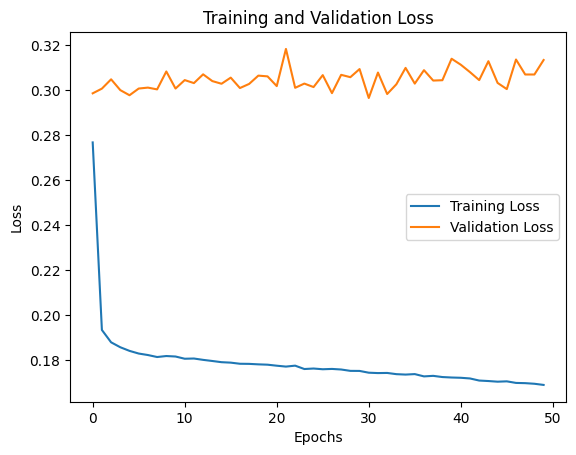

In [17]:
import matplotlib.pyplot as plt

# 评估模型
loss = model.evaluate(X_test_rnn, y_test_rnn)
print('测试集上的损失:', loss)

# 绘制训练和验证损失
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# 评估模型
# 使用验证集进行预测
y_val_pred_rnn = model.predict(X_val_rnn)

# 使用测试集进行预测
y_test_pred_rnn = model.predict(X_test_rnn)

# 计算RMSE
rmse_max_rnn = np.sqrt(mean_squared_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0]))
rmse_min_rnn = np.sqrt(mean_squared_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1]))

# 计算MSE
mse_max_rnn = mean_squared_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
mse_min_rnn = mean_squared_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

# 计算MAE
mae_max_rnn = mean_absolute_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
mae_min_rnn = mean_absolute_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

# 计算R²
r2_max_rnn = r2_score(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
r2_min_rnn = r2_score(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

print(f"RMSE of 'max_temp' in test set: {rmse_max_rnn}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rnn}")

print(f"MSE of 'max_temp' in test set: {mse_max_rnn}")
print(f"MSE of 'min_temp' in test set: {mse_min_rnn}")

print(f"MAE of 'max_temp' in test set: {mae_max_rnn}")
print(f"MAE of 'min_temp' in test set: {mae_min_rnn}")

print(f"R² of 'max_temp' in test set: {r2_max_rnn}")
print(f"R² of 'min_temp' in test set: {r2_min_rnn}")


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
RMSE of 'max_temp' in test set: 0.5285702691356324
RMSE of 'min_temp' in test set: 0.5905610530126105
MSE of 'max_temp' in test set: 0.2793865294141149
MSE of 'min_temp' in test set: 0.3487623573353633
MAE of 'max_temp' in test set: 0.40703329394204063
MAE of 'min_temp' in test set: 0.4573847349468734
R² of 'max_temp' in test set: 0.7130553926907965
R² of 'min_temp' in test set: 0.6454279644318992
